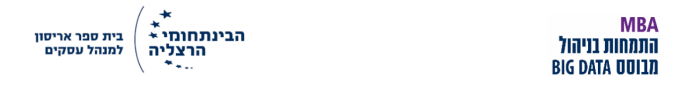


<font size="7">ML Methodologies for Business</font> <br>
<font size="6">Assignment 3 - Final Project </font> <br>
<font size="5">Ehud Sherel and Itay Oren</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import os
import spacy
import re,string,unicodedata
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import tensorflow as tf

from textblob import TextBlob
from textblob import Word

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import word_tokenize,sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model

from scipy.sparse import csr_matrix, lil_matrix 

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Question 1 – Data retrieval, description, text preprocessing and feature extractions


## 1) Load the data

In [ ]:
file =pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset/Online Shopping Clothing Reviews.csv',index_col=0)

In [ ]:
file.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
file.columns = ['id', 'reviewer_age', 'title', 'review_text', 'rating', 'recommended_ind', 'positive_feedback_count', 'div_name', 'dept_name', 'class']
file.describe()

,id,reviewer_age,rating,recommended_ind,positive_feedback_count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


In [ ]:
file[file.positive_feedback_count>100]

,id,reviewer_age,title,review_text,rating,recommended_ind,positive_feedback_count,div_name,dept_name,class
1294,1095,29,NaN,I've been on the hunt for the perfect dress to...,5,1,117,General,Dresses,Dresses
7218,1092,34,Beware if you're fuller in the chest,I loved the lace detailing all over this dress...,3,1,122,General,Dresses,Dresses
7765,986,43,Quality does not merit cost,"I generally don't write bad reviews, but there...",1,0,108,General,Jackets,Jackets





## 2) Finding interesting facts about the data

**Observatoin #1** - We can see that the mean of recommended_ind is 0.82. Thus, it means that this is our base for any ML model. If a model will always predict "1" -- positive recomendation - it will be accurate at 82%. 
This is a key observation for later on.

**Obesrvation #2**
We can see that the average rating age is 43 years old , and overall the average rating it ~4.2 (in the scale between 1-5 it means that overall most of the ratings are very possitve - 50% of the ratings are 5)

We can see that there were three items which recieved more than 100 positive feedback - from this we can conlude
1. item id 1095 which got rating =5 is loved by our customers and we should try and market it to similar customers progile.
2. item id 986 is not loved by our customers and we should consider remove from the our store. 

### Which class has the more ratings:

In [ ]:
classes_df = file.groupby(['class']).agg({'reviewer_age': np.mean, 'rating': np.mean, 'positive_feedback_count': np.sum, 'div_name': np.size})
classes_df.head().sort_values('rating', ascending=False)

,reviewer_age,rating,positive_feedback_count,div_name
class,,,,
Casual bottoms,26.500000,4.500000,0,2
Fine gauge,44.730909,4.260909,2215,1100
Blouses,44.252502,4.154020,8440,3097
Dresses,42.114892,4.150815,19510,6319
Chemises,38.000000,4.000000,0,1


In [ ]:
classes_df = classes_df.reset_index()
classes_df.columns = ['class', 'reviewer_age', 'rating', 'positive_feedback_count', 'counter']
classes_df.head()

,class,reviewer_age,rating,positive_feedback_count,counter
0,Blouses,44.252502,4.154020,8440,3097
1,Casual bottoms,26.500000,4.500000,0,2
2,Chemises,38.000000,4.000000,0,1
3,Dresses,42.114892,4.150815,19510,6319
4,Fine gauge,44.730909,4.260909,2215,1100


In [ ]:
bottom_limit = int(round(len(file) *0.01))
percent_limit_products_df = classes_df.loc[classes_df.counter > bottom_limit]
percent_limit_products_df.head()

,class,reviewer_age,rating,positive_feedback_count,counter
0,Blouses,44.252502,4.154020,8440,3097
3,Dresses,42.114892,4.150815,19510,6319
4,Fine gauge,44.730909,4.260909,2215,1100
6,Jackets,43.813920,4.295455,1990,704
7,Jeans,43.115955,4.360942,2018,1147


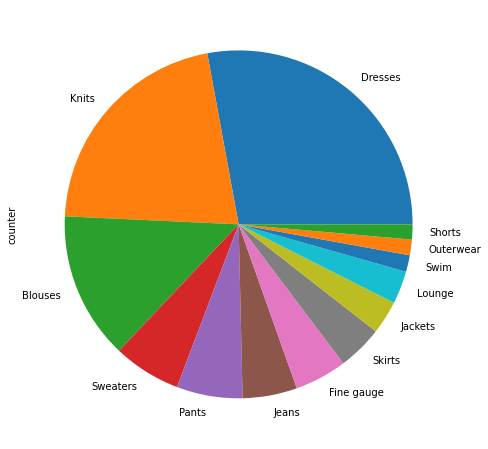

In [ ]:
percent_limit_products_df = percent_limit_products_df.sort_values(by='counter', ascending=False)
percent_limit_products_df[['class', 'counter']].set_index('class').plot.pie(y='counter', figsize=(8,8), legend=False)
plt.show()

**Obesrvation #3** We can see that dresses has the most number of ratings left. 
This is important since it might mean that women tend to leave more ratings and although we need further customer information to better understand this, it might affect future desicions of the company

### Does age correlates rating:

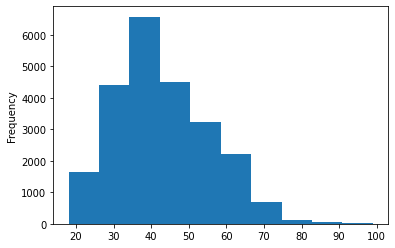

In [ ]:
file.reviewer_age.plot.hist()
plt.show()

First, we see that there's a nice normal distibution around the age of 40 when it comes to number of ratings. Now let's see what about the rating numbers themselves

In [ ]:
ages_df = file[['reviewer_age', 'rating']]
ages_df.reviewer_age = ages_df.reviewer_age.astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
for idx, row in ages_df.iterrows():
  if ages_df.loc[idx, 'reviewer_age'] <= 20:
    ages_df.loc[idx, 'reviewer_age'] = '0 to 20'
  elif ages_df.loc[idx, 'reviewer_age'] <= 40: 
    ages_df.loc[idx, 'reviewer_age'] = '21 to 40'
  elif ages_df.loc[idx, 'reviewer_age'] <= 60: 
    ages_df.loc[idx, 'reviewer_age'] = '41 to 60'
  elif ages_df.loc[idx, 'reviewer_age'] <= 80: 
    ages_df.loc[idx, 'reviewer_age'] = '61 to 80'
  else:
    ages_df.loc[idx, 'reviewer_age'] = '81 to 100'
ages_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,reviewer_age,rating
0,21 to 40,4
1,21 to 40,5
2,41 to 60,3
3,41 to 60,5
4,41 to 60,5


In [ ]:
bins_df = ages_df.groupby('reviewer_age').mean()
bins_df.head()

,rating
reviewer_age,
0 to 20,4.322368
21 to 40,4.172373
41 to 60,4.198183
61 to 80,4.280154
81 to 100,4.454545


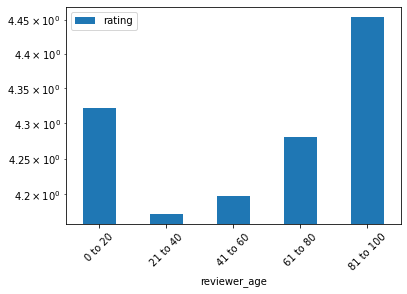

In [ ]:
bins_df.plot.bar(logy= True, rot=45)
plt.show()

**Obesrvation #4** It's interesting to see that although people around their 40's leave more ratings than others, they usually rate lower than others.
This might have an impact on future decisions when thinking about how to get those rating numbers higher

## 3) Text PreProcessing Steps




In [ ]:
file.head()

,id,reviewer_age,title,review_text,rating,recommended_ind,positive_feedback_count,div_name,dept_name,class
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


**We see no point on keeping both title and review_text columns - we will merge them to one review column**

In [ ]:
#cleaning NA data
file.isna().sum()


id                            0
reviewer_age                  0
title                      3810
review_text                 845
rating                        0
recommended_ind               0
positive_feedback_count       0
div_name                     14
dept_name                    14
class                        14
dtype: int64

In [ ]:
file= file.fillna(' ')
file.isna().sum()


id                         0
reviewer_age               0
title                      0
review_text                0
rating                     0
recommended_ind            0
positive_feedback_count    0
div_name                   0
dept_name                  0
class                      0
dtype: int64

In [ ]:
file.review_text = file.review_text.apply(str)
file.title = file.title.apply(str)

In [ ]:
file['review'] = file.title.str.cat(file.review_text)
file.head()
#del file['title']
#del file['review_text']
file.head()


,id,reviewer_age,title,review_text,rating,recommended_ind,positive_feedback_count,div_name,dept_name,class,review
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flawsI had such high hopes f...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy!I love, love, love this jumpsu..."
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirtThis shirt is very flattering ...


In [ ]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
nltk.download('stopwords')
stopword_list = stopwords.words('english')
#print(len(stopword_list))
#stopword_list[0:10]
#set stopwords to english
stop=set(stopwords.words('english'))

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
file['review']=file['review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
#imdb_data['review']=imdb_data['review'].apply(remove_special_characters)
file['review']=file['review'].apply(remove_special_characters)

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
    
#Apply function on review column
file['review']=file['review'].apply(denoise_text)

In [ ]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
file['review']=file['review'].apply(remove_special_characters)


In [ ]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
file['review']=file['review'].apply(simple_stemmer)

## 4) preperaing for BOW and TFIDF model

**Spliting data to test and train**

In [ ]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(file.recommended_ind)
print(sentiment_data.shape)

(23486, 1)


In [ ]:
trian_size = round(len(file.recommended_ind)/4 *3)   # Split to 75% of train andand 25% of test data
#Train Data
train_reviews=file.review[:trian_size]
#train_sentiments=file.recommended_ind[:trian_size]
train_sentiments=sentiment_data[:trian_size]
#Test Data
test_reviews=file.review[trian_size:]
#test_sentiments=file.recommended_ind[trian_size:]
test_sentiments=sentiment_data[trian_size:]



In [ ]:
train_reviews[0]

'absolut wonder silki sexi comfort'

In [ ]:
#Count vectorizer for bag of words
#cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv=CountVectorizer(min_df=5,ngram_range=(1,4))
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#transformed train reviews
cv_train_reviews=cv.fit_transform(train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(test_reviews)

##cv_train_reviews = cv_train_reviews.toarray()
##cv_test_reviews = cv_test_reviews.toarray()

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)


BOW_cv_train: (17614, 23183)
BOW_cv_test: (5872, 23183)


In [ ]:
#Tfidf vectorizer
#tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
tv=TfidfVectorizer(min_df=5,ngram_range=(1,4))
#transformed train reviews
tv_train_reviews=tv.fit_transform(train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (17614, 23183)
Tfidf_test: (5872, 23183)


5) Creating Features 

We will try to create some weight for the postive feedback count to emphsize the rating which was given. 
For that we multiply the raitng with the positive feedback count.


In [ ]:
file['weighted_rating']= file.rating*(1+file.positive_feedback_count) 
file.head()

,id,reviewer_age,title,review_text,rating,recommended_ind,positive_feedback_count,div_name,dept_name,class,review,weighted_rating
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort,4
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretti happen find store glad ...,25
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,major design flawsi high hope dress realli wan...,3
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,favorit buy love love love jumpsuit fun flirti...,5
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,flatter shirtthi shirt flatter due adjust fron...,35


In [ ]:
file['words_count'] = file['review_text'].str.split().str.len()


In [ ]:
file.head()

,id,reviewer_age,title,review_text,rating,recommended_ind,positive_feedback_count,div_name,dept_name,class,review,weighted_rating,words_count
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort,4,8
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretti happen find store glad ...,25,62
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,major design flawsi high hope dress realli wan...,3,98
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,favorit buy love love love jumpsuit fun flirti...,5,22
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,flatter shirtthi shirt flatter due adjust fron...,35,36


# Question 2 - creating a dictionary

## 1) Implementing a dictionary based analysis *classifier*

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment = sid.polarity_scores("The food was very bad")
sentiment

{'compound': -0.5849, 'neg': 0.487, 'neu': 0.513, 'pos': 0.0}

In [ ]:
dict_based_df = file[['id','recommended_ind', 'review']]
dict_based_df.head()

,id,recommended_ind,review
0,767,1,absolut wonder silki sexi comfort
1,1080,1,love dress sooo pretti happen find store glad ...
2,1077,0,major design flawsi high hope dress realli wan...
3,1049,1,favorit buy love love love jumpsuit fun flirti...
4,847,1,flatter shirtthi shirt flatter due adjust fron...


In [ ]:
for idx, row in dict_based_df.iterrows():
  dict_based_df.loc[idx, 'vl_compound'] = sid.polarity_scores(dict_based_df.loc[idx, 'review'])['compound']
dict_based_df.head()  

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,id,recommended_ind,review,vl_compound
0,767,1,absolut wonder silki sexi comfort,0.3612
1,1080,1,love dress sooo pretti happen find store glad ...,0.9349
2,1077,0,major design flawsi high hope dress realli wan...,0.9186
3,1049,1,favorit buy love love love jumpsuit fun flirti...,0.9753
4,847,1,flatter shirtthi shirt flatter due adjust fron...,0.8957


## 2) Comparing to textblob sentiment method


Adding the textblob polarity column

In [ ]:
for idx, row in dict_based_df.iterrows():
  dict_based_df.loc[idx, 'text_blob_polar'] = TextBlob(dict_based_df.loc[idx, 'review']).sentiment.polarity
dict_based_df.head()  

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,id,recommended_ind,review,vl_compound,text_blob_polar
0,767,1,absolut wonder silki sexi comfort,0.3612,0.000000
1,1080,1,love dress sooo pretti happen find store glad ...,0.9349,0.462500
2,1077,0,major design flawsi high hope dress realli wan...,0.9186,0.069006
3,1049,1,favorit buy love love love jumpsuit fun flirti...,0.9753,0.520000
4,847,1,flatter shirtthi shirt flatter due adjust fron...,0.8957,0.458333


In [ ]:
corr_results = dict_based_df[['recommended_ind', 'vl_compound', 'text_blob_polar']].corr()
print(corr_results['recommended_ind'])

recommended_ind    1.000000
vl_compound        0.247450
text_blob_polar    0.214681
Name: recommended_ind, dtype: float64


Seems like the vader_lexicon is a bit more correlated with the recommended column, though we still found some issues with both models when manually checked on the reviews and data

# Question 3 - Classification models

### (1) **Our Classificaiton Question** -  

## What is the likelihood that a product will be recomened by our customers ?
###  On one model we will try to predict this question based on the review
###  On second model we will try to predict this based on the normalized rating.

The Buisness imporant is to feagure out if a text review is more important than a random rating number. 
We do see on the data (for example in line 2) - that people can rate a product as 3 but not to recomend it. 

If we will understand that text can predict better a user recomendation - we might focus on social media or even to ease people text review writing. 

### (2) Implement Logistic Regrssion Clasifier 

*Our Choise is to compare the features vs Logistic Regression Model*




In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 ... 0 1 1]
[1 1 1 ... 1 1 1]


### (3) Logistic Regrssion Model resutls

In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8596730245231607
lr_tfidf_score : 0.8928814713896458


In [ ]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.57      0.84      0.68      1043
    Negative       0.96      0.86      0.91      4829

    accuracy                           0.86      5872
   macro avg       0.77      0.85      0.79      5872
weighted avg       0.89      0.86      0.87      5872

              precision    recall  f1-score   support

    Positive       0.83      0.50      0.62      1043
    Negative       0.90      0.98      0.94      4829

    accuracy                           0.89      5872
   macro avg       0.87      0.74      0.78      5872
weighted avg       0.89      0.89      0.88      5872



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4174  655]
 [ 169  874]]
[[4726  103]
 [ 526  517]]


**Testing the same Logistic regression model on our features set.**

In [ ]:
#spliting our features data set into train and test.
rating_file = file[["weighted_rating"]]
words_file = file[["words_count"]]

rate_train_data = rating_file[:trian_size]
rate_test_data = rating_file[trian_size:]

words_train_data = words_file[:trian_size]
words_test_data = words_file[trian_size:]


lr_rating=lr.fit(rate_train_data,train_sentiments)
lr_words=lr.fit(words_train_data,train_sentiments)

lr_rating_predict=lr.predict(rate_test_data)
lr_words_predict=lr.predict(words_test_data)

lr_rating_score=accuracy_score(test_sentiments,lr_rating_predict)
lr_words_score=accuracy_score(test_sentiments,lr_words_predict)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("lr_training_score :",lr_rating_score)
print("lr_words_score :",lr_words_score)

lr_training_score : 0.8222070844686649
lr_words_score : 0.8223773841961853


In [ ]:
#confusion matrix for ratings model
cm_rating=confusion_matrix(test_sentiments,lr_rating_predict,labels=[1,0])
print(cm_rating)
#confusion matrix for couting words in review
cm_words=confusion_matrix(test_sentiments,lr_words_predict,labels=[1,0])
print(cm_words)

[[4828    1]
 [1043    0]]
[[4829    0]
 [1043    0]]


### (4)  Conclusions
*   As we can see , trying to predict the recomendation based on "regualr", analytic features , did not manage to predict better than the "obvious" model - a Model which will just predict "positive recomendation" all the time.
We can see this very clearly in thier Confusion Matix.
*   Even the basic LR model for BOW and TF-IDF , need to get some tuning. 
Only once minimzing the count vectorization to min_df =5 and loading large ngram , we have managed to get both model better than the 82%.

*   As we saw, TF-IDF enabled ~89.3% accuracy, where BOW scored 85.9%. 







# Question 4 - Deep learning classification

In [ ]:
file.head()

,id,reviewer_age,title,review_text,rating,recommended_ind,positive_feedback_count,div_name,dept_name,class,review,weighted_rating,words_count
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort,4,8
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretti happen find store glad ...,25,62
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,major design flawsi high hope dress realli wan...,3,98
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,favorit buy love love love jumpsuit fun flirti...,5,22
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,flatter shirtthi shirt flatter due adjust fron...,35,36


In [ ]:
# Model configuration
max_sequence_length = 100
num_distinct_words = 10000
embedding_output_dims = 15
loss_function = 'binary_crossentropy'
optimizer = 'adam'
additional_metrics = ['accuracy']
number_of_epochs = 100
verbosity_mode = True
validation_split = 0.20

In [ ]:
cv=CountVectorizer()
train_size = round(len(file.recommended_ind)/4 *3)   # Split to 75% of train andand 25% of test data
x_train=cv.fit_transform(file.review[:train_size]).toarray() 
x_test=cv.transform(file.review[train_size:]).toarray()

In [ ]:
print('BOW_cv_train:',x_train.shape) 
print('BOW_cv_test:',x_test.shape)

BOW_cv_train: (17614, 15977)
BOW_cv_test: (5872, 15977)


In [ ]:
lb=LabelBinarizer()
lables=lb.fit_transform(file.recommended_ind)

In [ ]:
y_train=lil_matrix(lables[:train_size]).toarray() 
y_test=lables[train_size:] 
print('train_ratings:',y_train.shape) 
print('test_ratings:',y_test.shape)

train_ratings: (17614, 1)
test_ratings: (5872, 1)


In [ ]:
max_sequence_length= x_train.shape[1] 
print('max_sequence_length', max_sequence_length)

max_sequence_length 15977


In [ ]:
size_vec = [len(x) for x in x_train]

In [ ]:
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0)
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0)

In [ ]:
# Define the Keras model
model = Sequential()
model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
model.add(Dropout(0.50))
model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.50))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.50))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Give a summary
model.summary()

# Train the model
history = model.fit(padded_inputs, y_train, epochs=50, verbose=verbosity_mode, validation_split=validation_split)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15977, 15)         150000    
_________________________________________________________________
dropout (Dropout)            (None, 15977, 15)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 15977, 32)         992       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15977, 32)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7988, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 255616)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 255616)            0

In [ ]:
# Test the model after training
test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

Test results - Loss: 0.3803250789642334 - Accuracy: 88.21526169776917%


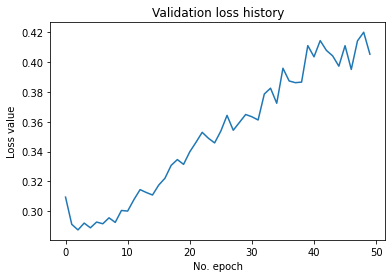

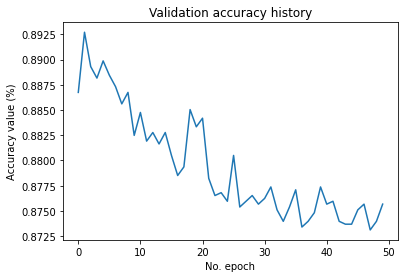

In [ ]:
# Visualize history
# Plot history: Validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

###Conclusions
The deep learning model we got are significantly better than the LR model for BOW and TF-IDF models we ran on question 3.
We can also see that we can use less epochs in order to echive results closer to 89%. Still this model works better for our business question

# Question 5 - BERT based classification

In [ ]:
pip install transformers

     |████████████████████████████████| 1.5MB 17.3MB/s 
     |████████████████████████████████| 890kB 54.3MB/s 
     |████████████████████████████████| 2.9MB 52.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4662883b6006008ce824052d76dbf0428a0b9a61eb1e1de32b3df04f5c51554f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_40 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train = file[['review', 'recommended_ind']][:train_size]
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,absolut wonder silki sexi comfort,1
1,love dress sooo pretti happen find store glad ...,1
2,major design flawsi high hope dress realli wan...,0
3,favorit buy love love love jumpsuit fun flirti...,1
4,flatter shirtthi shirt flatter due adjust fron...,1


In [ ]:
test = file[['review', 'recommended_ind']][train_size:]
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test.head()

,DATA_COLUMN,LABEL_COLUMN
17614,great skirt bad craftmanshipalreadi got lot co...,1
17615,dress teethi top eye catcher bat love noth dre...,1
17616,great shirti bought green dark teal fabric sof...,1
17617,normal wear medium everyth bet xs would mayb f...,0
17618,comfort amp styleth shirt fit loos baggi beaut...,1


In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  # train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
  #                                                                          test, 
  #                                                                          'DATA_COLUMN', 
  #                                                                          'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [ ]:
DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

In [ ]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fae35795d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fae35795d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


   1102/Unknown - 942s 817ms/step - loss: 0.3018 - accuracy: 0.8736

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1102/1102 [==============================] - 997s 866ms/step - loss: 0.3018 - accuracy: 0.8737 - val_loss: 0.2392 - val_accuracy: 0.8985
Epoch 2/2
1102/1102 [==============================] - 954s 865ms/step - loss: 0.1367 - accuracy: 0.9492 - val_loss: 0.3323 - val_accuracy: 0.9017


In [ ]:
bert_results = model.evaluate(validation_data)
print(f'Test results - Loss: {bert_results[0]} - Accuracy: {100*bert_results[1]}%')

184/184 [==============================] - 52s 285ms/step - loss: 0.3323 - accuracy: 0.9017
Test results - Loss: 0.3322567939758301 - Accuracy: 90.17370343208313%


###Conclusions
We can see that the BERT model got the best accuracy out of all of the models we trained with accuracy of a bit over 90%.
This model however takes much more time (and we only trained 2 epochs) so the question of which model to choose is a matter of resources, though the BERT model is preffered.